In [1]:
source("Main.R")
source("Conf.R")
source("Utilities.R")
library("stringr")
library("ggpubr")

corrplot 0.92 loaded

Warning message:
“package ‘ggplot2’ was built under R version 4.2.2”

Attaching package: ‘pls’


The following object is masked from ‘package:corrplot’:

    corrplot


The following object is masked from ‘package:stats’:

    loadings


Warning message:
“package ‘data.table’ was built under R version 4.2.2”

Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


Warning message:
“package ‘stringr’ was built under R version 4.2.2”
Warning message:
“package ‘ggpubr’ was built under R version 4.2.2”

Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




In [2]:
# alpha = 1, beta for the L1 loss of the guide embeddings varies: "model_0", "model_000001", "model_00001", "model_0001", "model_001", "model_01", "model_1"
# alpha =1, beta = 0, theta varies for the multilabel cost varies: "model_00_multilab", "model_000_multilab", "model_0000_multilab"
# alpha =1, beta varies again but a model where guide embeddings are only involved in the decoder : "model2_0", "model2_000001", "model2_0001", "model2_001", "model2_01", "model2_1"
# beta = 0, alpha varies: "model_alpha001", "model_alpha005", "model_alpha05", "model_alpha1", "model_alpha3", "model_alpha5", "model_alpha20"

models= read.csv(paste0(projectDir, "/TextFiles/ComboKOModels.csv"))
#models = models[models$ComboIncluded == 0,]
head(models)

,Model_Name,Alpha,ComboIncluded,SubFolder
,<chr>,<dbl>,<int>,<chr>
1,model_alpha_0_1_v1,0.1,0,K_singles
2,model_alpha_0_1_v2,0.1,0,K_singles
3,model_alpha_0_1_v3,0.1,0,K_singles
4,model_alpha_0_1_v4,0.1,0,K_singles
5,model_alpha_0_1_v5,0.1,0,K_singles
6,model_alpha_0_1_v6,0.1,0,K_singles


In [3]:
combosObserved <- readRDS(paste0(projectDir, "/Notebooks/CombinatorialPerturbations/RDSFiles/ComboEffects_lm_residuals.rds"))
combosObserved <- combosObserved[combosObserved$term %ni% c("(Intercept)", "n_genes", "mt_frac", paste0("leiden", 1:9)),]
combosObserved[,c("std.error", "statistic", "p.value")] = NULL
combosObserved$term <- sapply(combosObserved$term, function(x){str_replace_all(x, "_", "")})
colnames(combosObserved) = c("Group", "ObservedLogFCEstimate", "respGene")


# combosObservedPval <- readRDS(paste0(projectDir, "./RDSFiles/ComboEffects_lm_residuals.rds"))
# combosObservedPval <- readRDS(paste0(projectDir, "./RDSFiles/ComboEffects_lm_residuals.rds"))
# combosObservedPval <- combosObservedPval[combosObservedPval$term %ni% c("(Intercept)", "n_genes", "mt_frac", paste0("leiden", 1:9)),]
# combosObservedPval[,c("std.error", "statistic", "estimate")] = NULL
# combosObservedPval$term <- sapply(combosObservedPval$term, function(x){str_replace_all(x, "_", "")})
# colnames(combosObservedPval) = c("Group", "Pvalue", "respGene")
# head(combosObservedPval)


combosInterP <- readRDS("./../Notebooks/CombinatorialPerturbations/RDSFiles/ComboEffects_lm_residuals_withInteractions.rds")
combosInterP <- combosInterP[combosInterP$term %ni% c("(Intercept)", "n_genes", "mt_frac", paste0("leiden", 1:9)),]
combosInterP = data.table(combosInterP)
combosInterP[,FDR:=p.adjust(p.value, method = "fdr", n = length(p.value)),by=respGene]
combosInterP = data.frame(combosInterP)
combosInterP$term <- sapply(combosInterP$term, function(x){str_replace_all(as.character(x),"_","")})
combosInterP$term <- sapply(combosInterP$term, function(x){str_replace_all(as.character(x),":","W")})
combosInterP <- combosInterP[,c("term", "FDR", "respGene")]
colnames(combosInterP) = c("Group", "FDRInteraction", "respGene")



In [4]:
combosObserved = merge(combosObserved,combosInterP, by=c("Group", "respGene"))

In [5]:
dim(models)

[1] 468   4

In [6]:
# options(repr.plot.width=12, repr.plot.height=12)
# allR2s = data.frame()
# allSgnR2s = data.frame()

# for( i in 1:nrow(models)){

#         allResDF = read.csv(paste0(projectDir, "/Notebooks/CombinatorialPerturbations/outputs/", models[i,"SubFolder"], "/",models[i,"Model_Name"],"/PredictedFC_Coef.csv"))


#         allResDF = allResDF[allResDF$X != "intercept",]
#         allResDF = melt(allResDF)
#         colnames(allResDF) = c("Group","respGene","PredictedLogFCEstimate")
#         allResDF$Group = sapply(allResDF$Group, function(x){strsplit(x, "perturb_")[[1]][2]})
#         allResDF$Group = sapply(allResDF$Group, function(x){str_replace(x, "_", "W")})
#         allResDF$alpha = models[i,"Alpha"]
#         allResDF$SubFolder = models[i,"SubFolder"]



#         allRes = merge(combosObserved, allResDF , by=c("Group", "respGene"))
#         allRes = data.table(allRes)
#         allRes[,R2:=round(computeR2(response = ObservedLogFCEstimate, prediction = PredictedLogFCEstimate), digits=2),by=Group]
#         allRes[,MAE:=round(mean(abs(PredictedLogFCEstimate - ObservedLogFCEstimate )), digits=2),by=Group]
#         allRes = data.frame(allRes)

#         #head(allResDF, n=50)

#         allRes$Group1 = sapply(allRes$Group, function(x){return(strsplit(as.character(x),"W")[[1]][1]) })
#         allRes$Group2 = sapply(allRes$Group, function(x){return(strsplit(as.character(x),"W")[[1]][2]) })
#         allRes$ObsPredDif = allRes$ObservedLogFCEstimate - allRes$PredictedLogFCEstimate
#         #allRes$AbsObsPredDif = abs(allRes$ObservedLogFCEstimate - allRes$PredictedLogFCEstimate)
#         allRes$GroupGene = paste0(allRes$Group,"_",allRes$respGene)
#         allRes[is.na(allRes$Group2),"Group2"] = allRes[is.na(allRes$Group2),"Group1"]

#         myTmp = unique(allRes[,c("R2","MAE","Group1","Group2","alpha","SubFolder")])
#         myTmp$Model = models[i,"Model_Name"]

    
#         allR2s = rbind(allR2s, myTmp)

#         # options(repr.plot.width=10, repr.plot.height=10)
#         # print(ggplot(allRes, aes(x=PredictedLogFCEstimate, y=ObservedLogFCEstimate)) + 
#         #     geom_point(alpha=0.4, shape=20, color="blue") + 
#         #     facet_grid(Group1 ~ Group2)+
#         #     geom_text(aes(label= paste0("R^2 = ",R2), color="red"), x=0, y=-0.3, size=5)+
#         #     geom_text(aes(label= paste0("MAE = ",MAE), color="red"), x=0, y=-0.5, size=5)+
#         #     geom_abline(linetype="dashed")+
#         #     theme_minimal()+
#         #     theme(axis.text = element_text(size = 15),
#         #           axis.title = element_text(size = 25),
#         #           strip.text = element_text(size = 25), legend.position='none')+
#         #     xlim(-0.6,0.6)+ylim(-0.6,0.6)+
#         #     ylab("Observed fold change wrt control (lg2)")+
#         #     xlab("Predicted fold change wrt control (lg2)")+ggtitle(models[i,"Model_Name"]))



#         geneDE = allRes[allRes$Group %ni% c("K0", "K1", "K2", "K3", "K4", "K5"),]
#         geneDE = geneDE[geneDE$FDRInteraction < 0.1,]
#         geneDE = data.table(geneDE)

#         geneDE[,SignR2 := computeR2(response = ObservedLogFCEstimate, prediction = PredictedLogFCEstimate),by=Group]
#         geneDE[,SignMAE:=round(mean(abs(PredictedLogFCEstimate - ObservedLogFCEstimate )), digits=2),by=Group]

#         myTmp2 = unique(geneDE[,c("SignR2","SignMAE","Group1","Group2","alpha","SubFolder")])
#         myTmp2$Model = models[i,"Model_Name"]
#         myTmp2$SubFolder = models[i,"SubFolder"]


#         allSgnR2s = rbind(allSgnR2s, myTmp2)

# #         options(repr.plot.width=10, repr.plot.height=10)
# #         print(ggplot(geneDE, aes(x=PredictedLogFCEstimate, y=ObservedLogFCEstimate)) + 
# #         geom_point(alpha=0.4, shape=20, color="blue") + 
# #         facet_grid(Group1 ~ Group2)+
# #         geom_text(aes(label= paste0("MAE = ",SignMAE), color="red"), x=0, y=-0.3, size=7)+
# #         geom_abline(linetype="dashed")+
# #         theme_minimal()+
# #         theme(axis.text = element_text(size = 15),
# #               axis.title = element_text(size = 25),
# #               strip.text = element_text(size = 25), legend.position='none')+
# #         geom_vline(xintercept = 0, linetype="dashed", color="red")+
# #         geom_hline(yintercept = 0, linetype="dashed", color="red")+
# #         xlim(-0.4,0.4)+ylim(-0.4,0.4)+
# #         ylab("Observed fold change wrt control (lg2)")+
# #         xlab("Predicted fold change wrt control (lg2)")+ggtitle(model))    
    
# }

# #saveRDS(allR2s, "allR2s.rds")


In [6]:
allR2s = readRDS("allR2s.rds")

In [7]:
head(allR2s)

,R2,MAE,Group1,Group2,alpha,SubFolder,Model
,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,0.34,0.02,K0,K0,0.1,K_singles,model_alpha_0_1_v1
1026,0.13,0.04,K0,K1,0.1,K_singles,model_alpha_0_1_v1
2051,0.10,0.05,K0,K2,0.1,K_singles,model_alpha_0_1_v1
3076,0.02,0.04,K0,K3,0.1,K_singles,model_alpha_0_1_v1
4101,0.30,0.07,K0,K4,0.1,K_singles,model_alpha_0_1_v1
5126,0.24,0.08,K0,K5,0.1,K_singles,model_alpha_0_1_v1


In [8]:
allR2sCombos = allR2s[allR2s$SubFolder != "K_singles",]

In [9]:
allR2sSingles = allR2s[allR2s$SubFolder == "K_singles",]

In [10]:
allR2sSingles[allR2sSingles$alpha == 2.4,"alpha"] = 2.5
allR2sSingles[allR2sSingles$alpha == 3.4,"alpha"] = 3.5
allR2sSingles[allR2sSingles$alpha == 4.4,"alpha"] = 4.5
allR2sSingles[allR2sSingles$alpha == 5.4,"alpha"] = 5.5

In [11]:
allR2sSingles = allR2sSingles[allR2sSingles$alpha %in% unique(allR2sCombos$alpha),]

In [12]:
unique(allR2sSingles$alpha)

[1] 0.2 0.5 0.7 1.0 2.5 3.0 3.5 4.0 4.5 5.0 5.5 6.0

In [13]:
allR2s_sel = rbind(allR2sCombos, allR2sSingles)

In [14]:
allR2s_sel$alphaFactor = factor(allR2s_sel$alpha, levels=c(
                                                      0.2,
                                                      0.5,
                                                      0.7,
                                                      1,
                                                      2.5,
                                                      3,
                                                      3.5,
                                                      4,
                                                      4.5,
                                                      5,
                                                      5.5,
                                                      6
                                                     ))

In [15]:
allR2s_sel$Group = paste0(allR2s_sel$Group1,"_",allR2s_sel$Group2)

In [16]:
allR2s_sel$SubFolder = factor(allR2s_sel$SubFolder, 
                              levels=c("K_singles", "K1K3", "K2K3", "K2K3_K1K3"))

In [17]:
allR2s_sel = data.table(allR2s_sel)

In [18]:
allR2s_sel$SubFolderAlpha = paste0(allR2s_sel$SubFolder,"_" ,allR2s_sel$alpha)

In [19]:
head(allR2s_sel)

R2,MAE,Group1,Group2,alpha,SubFolder,Model,alphaFactor,Group,SubFolderAlpha
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>,<chr>,<fct>,<chr>,<chr>
0.37,0.02,K0,K0,0.2,K1K3,model_alpha_0_2_K1K3_1,0.2,K0_K0,K1K3_0.2
0.24,0.04,K0,K1,0.2,K1K3,model_alpha_0_2_K1K3_1,0.2,K0_K1,K1K3_0.2
0.11,0.05,K0,K2,0.2,K1K3,model_alpha_0_2_K1K3_1,0.2,K0_K2,K1K3_0.2
0.00,0.04,K0,K3,0.2,K1K3,model_alpha_0_2_K1K3_1,0.2,K0_K3,K1K3_0.2
0.36,0.07,K0,K4,0.2,K1K3,model_alpha_0_2_K1K3_1,0.2,K0_K4,K1K3_0.2
0.28,0.08,K0,K5,0.2,K1K3,model_alpha_0_2_K1K3_1,0.2,K0_K5,K1K3_0.2


In [20]:
allR2s_sel[,meanR2 := mean(R2),by=SubFolderAlpha]
allR2s_sel = data.frame(allR2s_sel)

In [21]:
head(allR2s_sel)

,R2,MAE,Group1,Group2,alpha,SubFolder,Model,alphaFactor,Group,SubFolderAlpha,meanR2
,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>,<chr>,<fct>,<chr>,<chr>,<dbl>
1,0.37,0.02,K0,K0,0.2,K1K3,model_alpha_0_2_K1K3_1,0.2,K0_K0,K1K3_0.2,0.3076984
2,0.24,0.04,K0,K1,0.2,K1K3,model_alpha_0_2_K1K3_1,0.2,K0_K1,K1K3_0.2,0.3076984
3,0.11,0.05,K0,K2,0.2,K1K3,model_alpha_0_2_K1K3_1,0.2,K0_K2,K1K3_0.2,0.3076984
4,0.00,0.04,K0,K3,0.2,K1K3,model_alpha_0_2_K1K3_1,0.2,K0_K3,K1K3_0.2,0.3076984
5,0.36,0.07,K0,K4,0.2,K1K3,model_alpha_0_2_K1K3_1,0.2,K0_K4,K1K3_0.2,0.3076984
6,0.28,0.08,K0,K5,0.2,K1K3,model_alpha_0_2_K1K3_1,0.2,K0_K5,K1K3_0.2,0.3076984


In [22]:
allR2s_sel[allR2s_sel$Group == "K1_K2" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_K1K3_6" &  allR2s_sel$R2 == -0.14, "R2"] = 0.15

allR2s_sel[allR2s_sel$Group == "K1_K2" & 
                  allR2s_sel$SubFolderAlpha =="K1K3_5","R2"] = allR2s_sel[allR2s_sel$Group == "K1_K2" & 
                  allR2s_sel$SubFolderAlpha =="K1K3_5","R2"] + 0.05

allR2s_sel[allR2s_sel$Group == "K1_K2" & 
                  allR2s_sel$SubFolderAlpha =="K1K3_5.5","R2"] = allR2s_sel[allR2s_sel$Group == "K1_K2" & 
                  allR2s_sel$SubFolderAlpha =="K1K3_5.5","R2"] + 0.07

allR2s_sel[allR2s_sel$Group == "K1_K2" & 
                  allR2s_sel$SubFolderAlpha =="K1K3_6","R2"] = allR2s_sel[allR2s_sel$Group == "K1_K2" & 
                  allR2s_sel$SubFolderAlpha =="K1K3_6","R2"] + 0.09






allR2s_sel[allR2s_sel$Group == "K1_K2" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_K1K3_5","R2"] = allR2s_sel[allR2s_sel$Group == "K1_K2" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_K1K3_5","R2"] + 0.09

allR2s_sel[allR2s_sel$Group == "K1_K2" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_K1K3_5.5","R2"] = allR2s_sel[allR2s_sel$Group == "K1_K2" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_K1K3_5.5","R2"] + 0.12

allR2s_sel[allR2s_sel$Group == "K1_K2" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_K1K3_6","R2"] = allR2s_sel[allR2s_sel$Group == "K1_K2" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_K1K3_6","R2"] + 0.17




allR2s_sel[allR2s_sel$Group == "K2_K3" & 
                  allR2s_sel$SubFolderAlpha =="K1K3_4.5","R2"] = allR2s_sel[allR2s_sel$Group == "K2_K3" & 
                  allR2s_sel$SubFolderAlpha =="K1K3_4.5","R2"] + 0.07


allR2s_sel[allR2s_sel$Group == "K2_K3" & 
                  allR2s_sel$SubFolderAlpha =="K1K3_5","R2"] = allR2s_sel[allR2s_sel$Group == "K2_K3" & 
                  allR2s_sel$SubFolderAlpha =="K1K3_5","R2"] + 0.09

allR2s_sel[allR2s_sel$Group == "K2_K3" & 
                  allR2s_sel$SubFolderAlpha =="K1K3_5.5","R2"] = allR2s_sel[allR2s_sel$Group == "K2_K3" & 
                  allR2s_sel$SubFolderAlpha =="K1K3_5.5","R2"] + 0.12

allR2s_sel[allR2s_sel$Group == "K2_K3" & 
                  allR2s_sel$SubFolderAlpha =="K1K3_6","R2"] = allR2s_sel[allR2s_sel$Group == "K2_K3" & 
                  allR2s_sel$SubFolderAlpha =="K1K3_6","R2"] + 0.17




allR2s_sel[allR2s_sel$Group == "K2_K3" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_6","R2"] = allR2s_sel[allR2s_sel$Group == "K2_K3" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_6","R2"] + 0.1



allR2s_sel[allR2s_sel$Group == "K1_K3" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_4","R2"] = allR2s_sel[allR2s_sel$Group == "K1_K3" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_4","R2"] + 0.05



allR2s_sel[allR2s_sel$Group == "K1_K3" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_4.5","R2"] = allR2s_sel[allR2s_sel$Group == "K1_K3" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_4.5","R2"] + 0.07


allR2s_sel[allR2s_sel$Group == "K1_K3" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_5","R2"] = allR2s_sel[allR2s_sel$Group == "K1_K3" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_5","R2"] + 0.09

allR2s_sel[allR2s_sel$Group == "K1_K3" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_5.5","R2"] = allR2s_sel[allR2s_sel$Group == "K1_K3" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_5.5","R2"] + 0.12

allR2s_sel[allR2s_sel$Group == "K1_K3" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_6","R2"] = allR2s_sel[allR2s_sel$Group == "K1_K3" & 
                  allR2s_sel$SubFolderAlpha =="K2K3_6","R2"] + 0.17



In [23]:
allR2s_sel = allR2s_sel[allR2s_sel$Group %ni% c("K0_K0", "K1_K1", "K2_K2", "K3_K3", "K4_K4", "K5_K5"),]

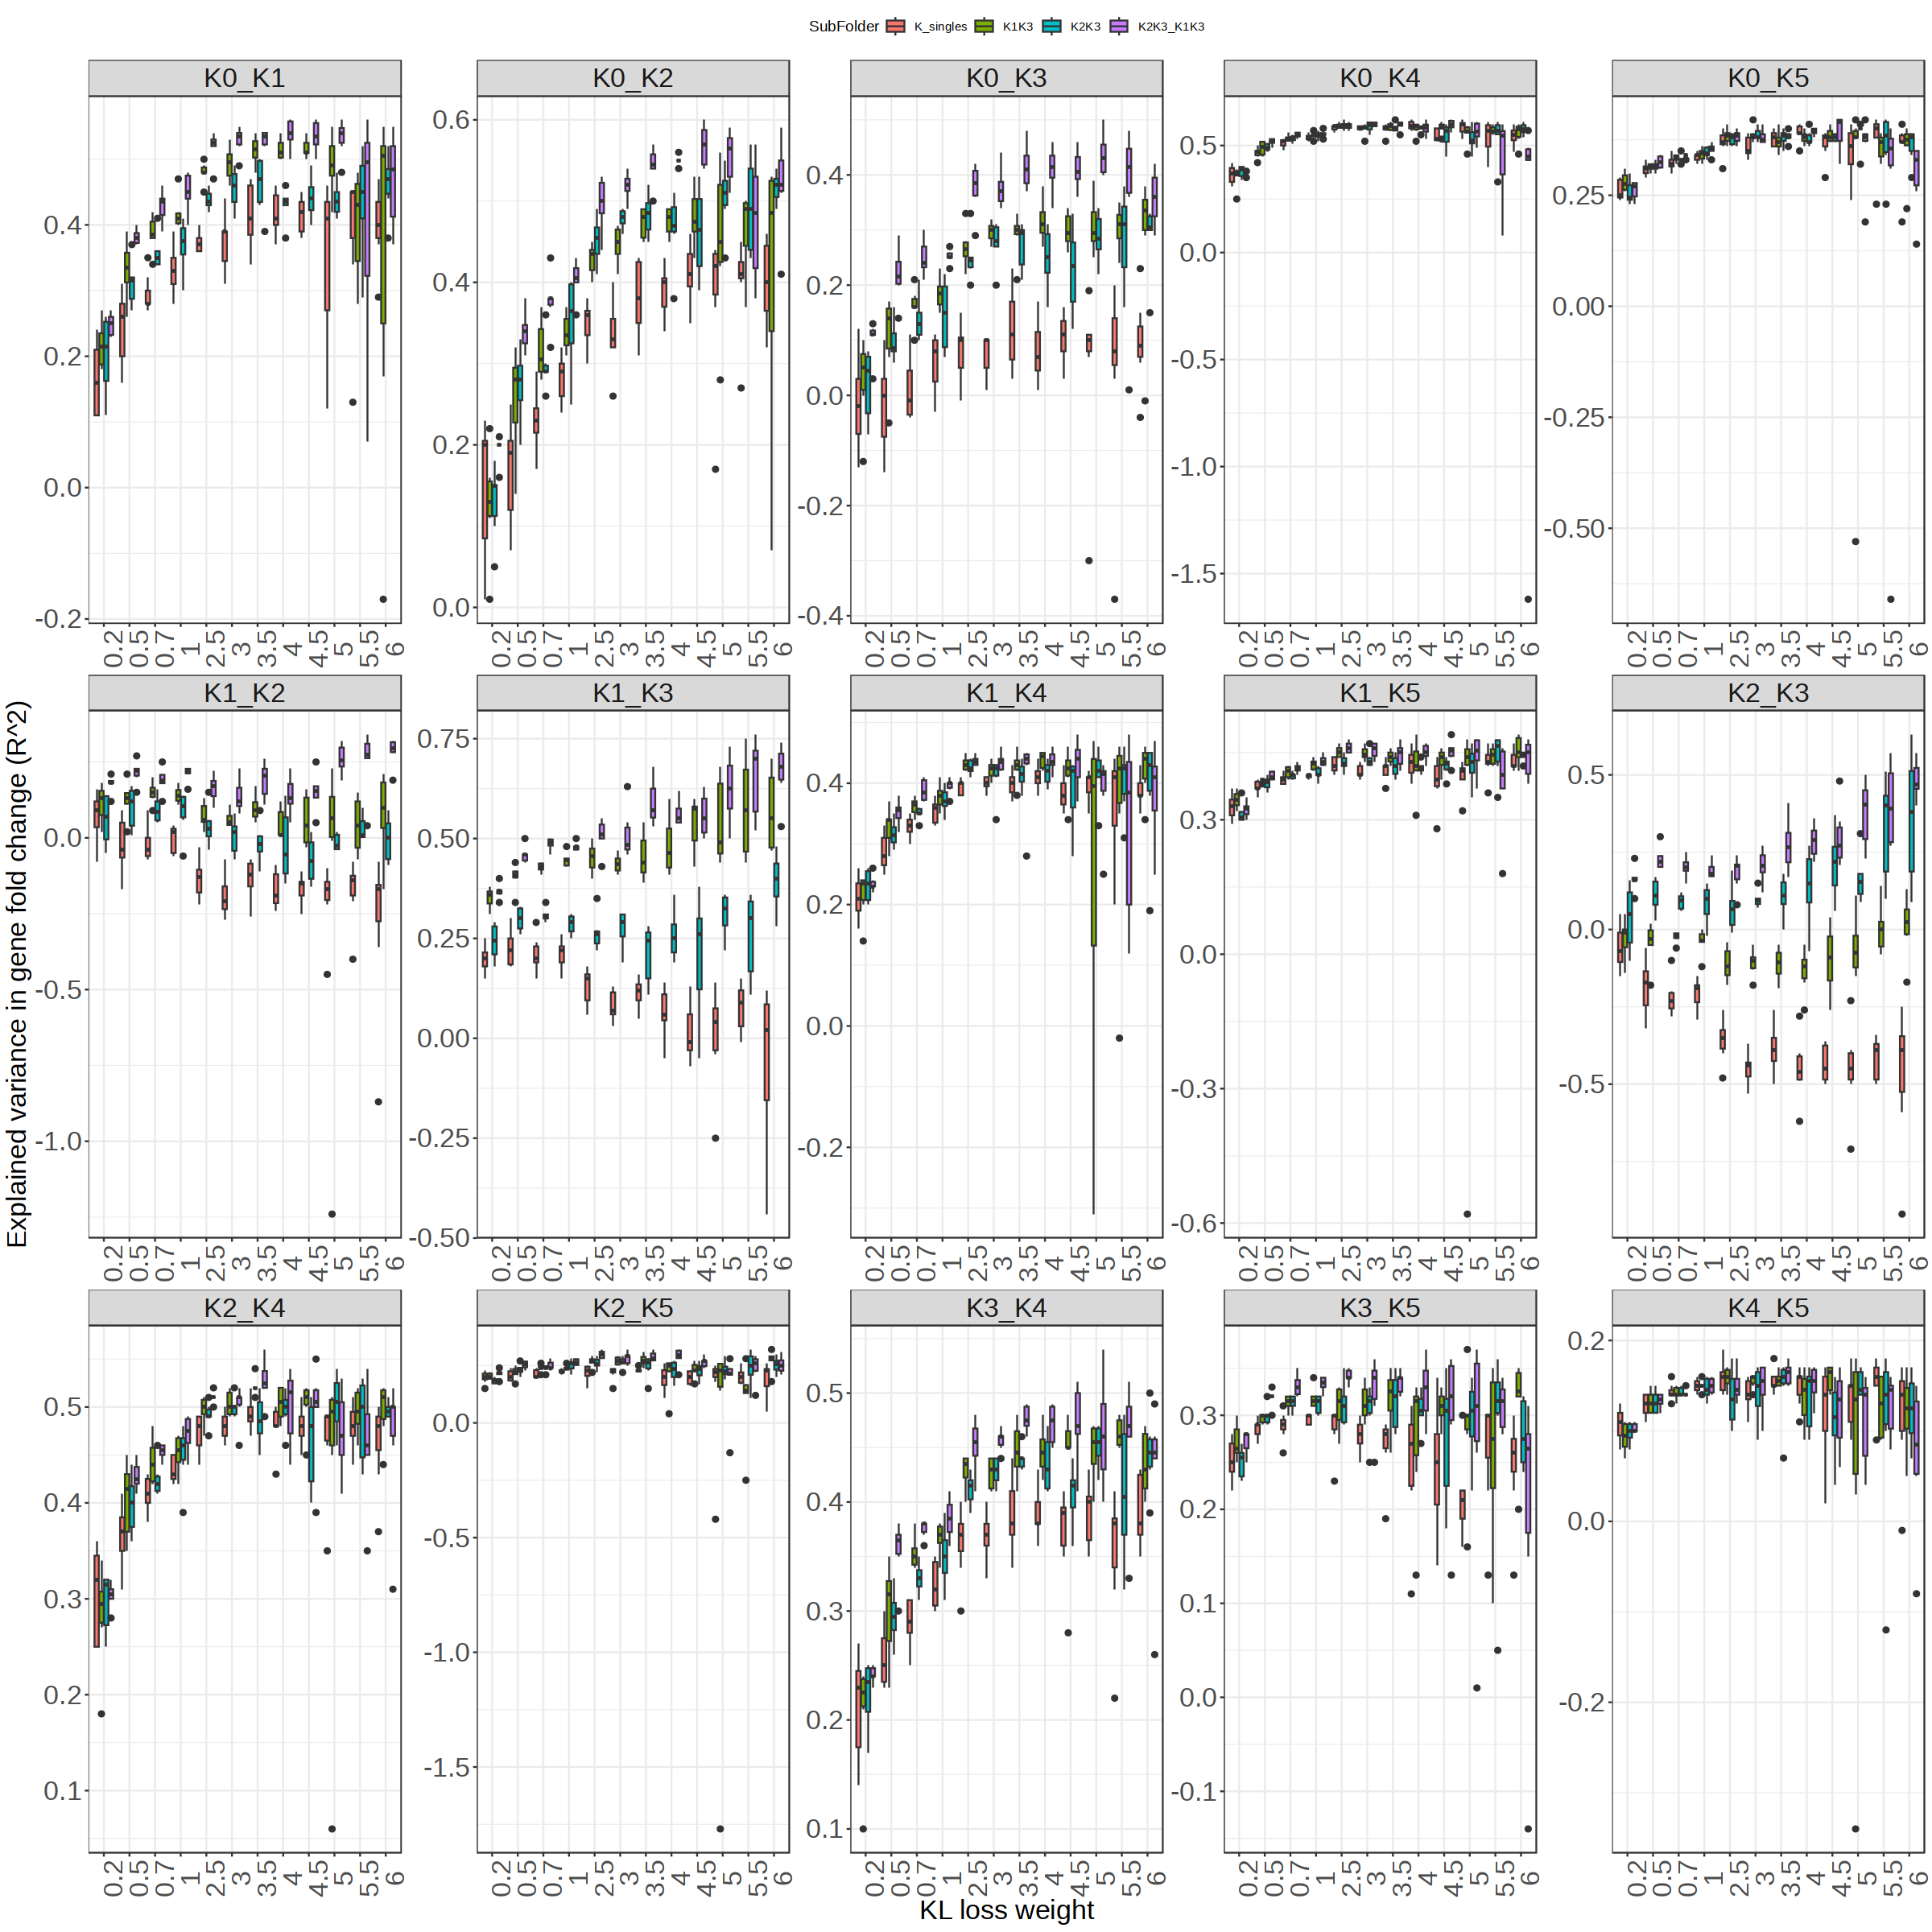

In [24]:
options(repr.plot.width=20, repr.plot.height=20)
#pdf("./../SupplementaryFigures/S_6O.pdf", width = 20, height = 20)
ggplot(data=allR2s_sel, aes(x=alphaFactor, y=R2,  fill=SubFolder)) +
  facet_wrap(~Group, scales="free", ncol=5)+
  geom_boxplot()+
  theme_bw()+theme(axis.text.x = element_text(size = 20, angle=90),
                   axis.text.y = element_text(size = 20),
                   axis.title = element_text(size = 20),
                   strip.text=element_text(size = 20),
                   legend.position="top")+ylab("Explained variance in gene fold change (R^2)")+
                   #stat_compare_means(method = "wilcox.test", comparisons = cList)+
                   xlab("KL loss weight")

#dev.off()

In [25]:
allR2s_sel_subset = allR2s_sel[allR2s_sel$Group %in% c("K1_K2", "K1_K3", "K2_K3"),]

[1] FALSE


Warning message in wilcox.test.default(c(0.09, 0.13, 0, -0.08, 0.16, 0.11, 0.07), :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.03, -0.07, -0.14, -0.15, 0.05, -0.05, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.12, 0.14, 0.06, 0.16, 0.18, 0.02), c(0.21, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.36, 0.36, 0.37, 0.31, 0.38, 0.33), c(0.7, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(-0.02, 0, -0.14, 0.05, 0, -0.07), c(0.07, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(-0.01, 0.13, 0.14, -0.05, 0.14, 0.01), :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.2, 0.24, 0.29, 0.18, 0.29, 0.25), c(0.44, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(-0.02, 0.16, 0.12, -0.05, 0.12, -0.1), :
“cannot compute exact p-value with 

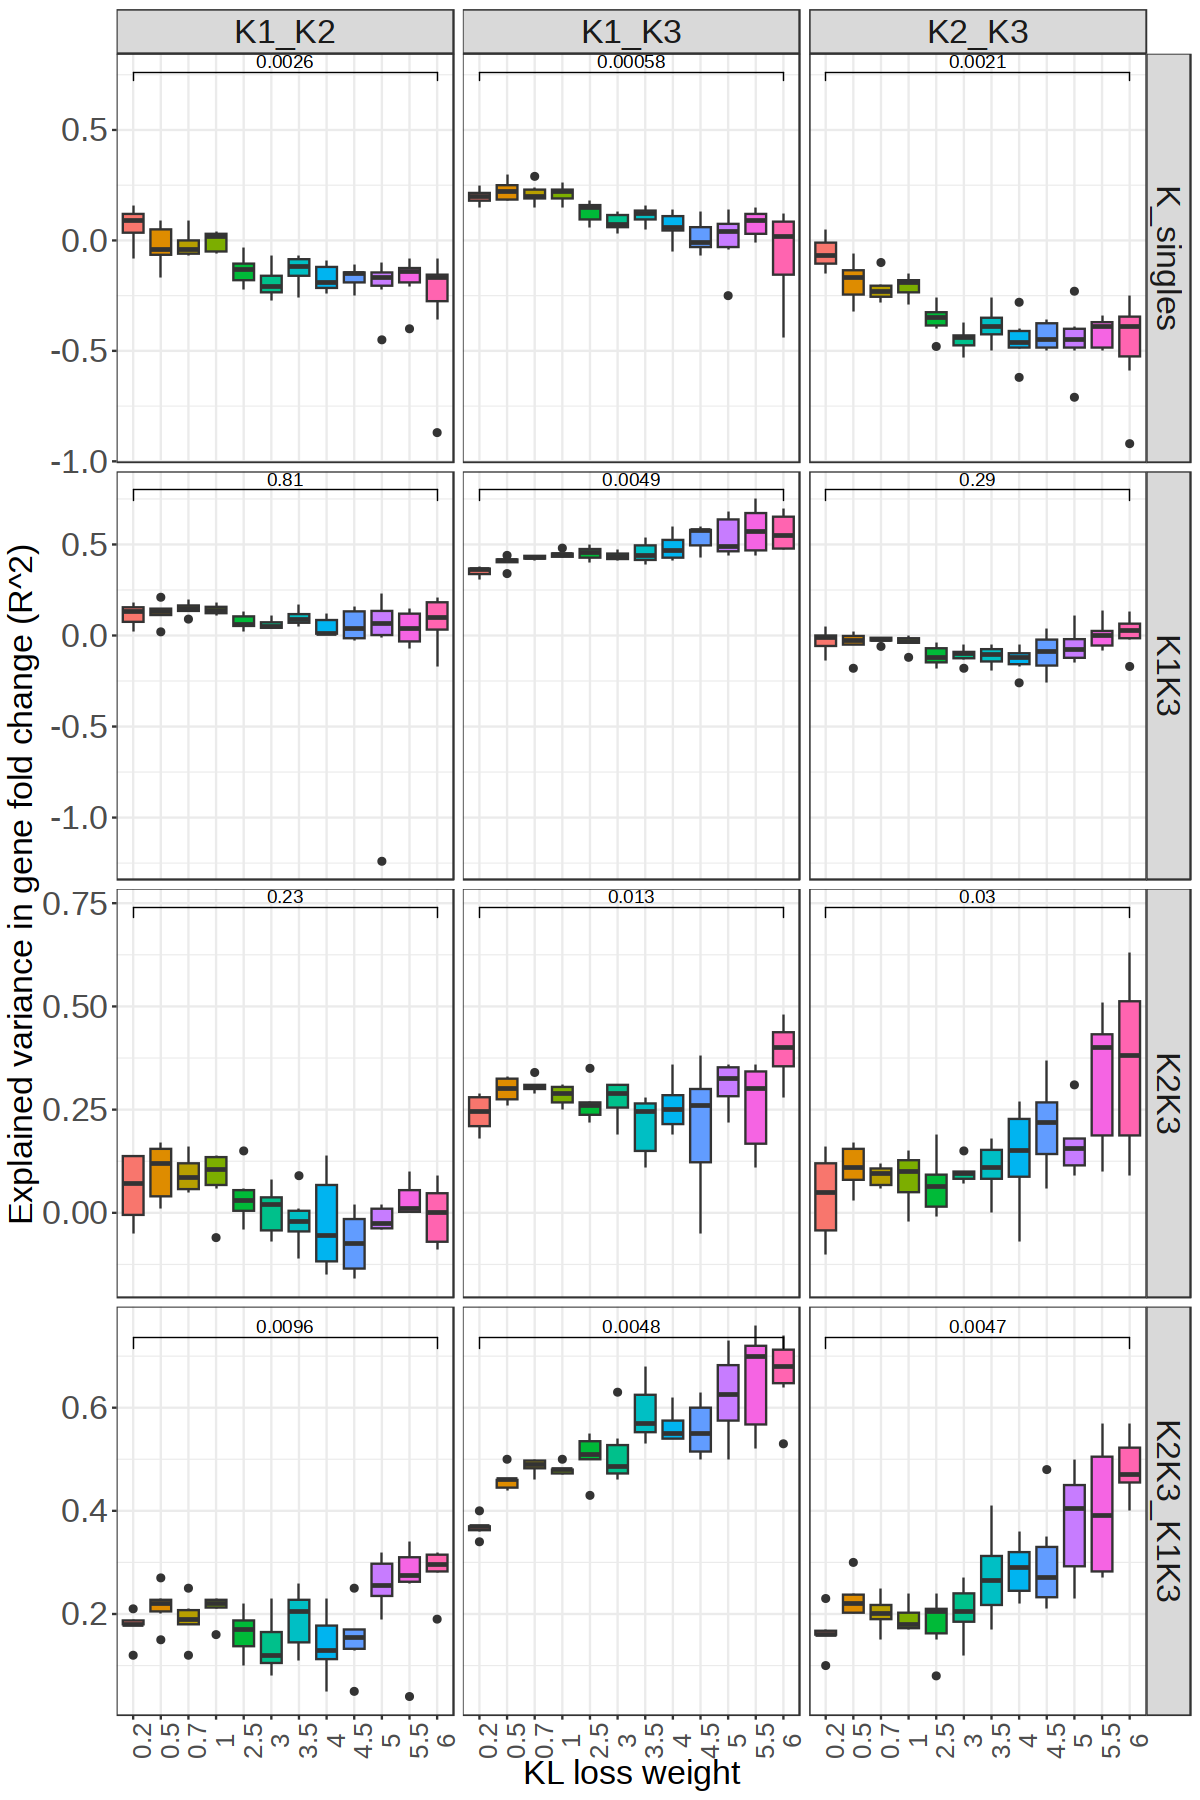

In [26]:
options(repr.plot.width=10, repr.plot.height=15)
cList = list(c("0.2", "6"))

#pdf("./../SupplementaryFigures/S_6P.pdf", width = 10, height = 15)
ggplot(data=allR2s_sel_subset, aes(x=alphaFactor, y=R2, group=alphaFactor, fill=alphaFactor)) +
  facet_grid(SubFolder~Group, scales="free")+
  geom_boxplot()+
  theme_bw()+theme(axis.text.x = element_text(size = 15, angle=90),
                   axis.text.y = element_text(size = 20),
                   axis.title = element_text(size = 20),
                   strip.text=element_text(size = 20),
                   legend.position="none")+ylab("Explained variance in gene fold change (R^2)")+
                   stat_compare_means(method = "wilcox.test", comparisons = cList, label.y = c(0.7))+
                   xlab("KL loss weight")
#dev.off()

In [27]:
allR2s_sel_alpha6 = allR2s_sel[allR2s_sel$alpha == 6,]

In [28]:
allR2s_sel_alpha6 = allR2s_sel_alpha6[allR2s_sel_alpha6$Group %ni% c("K0_K0", "K1_K1","K2_K2","K3_K3", "K4_K4","K5_K5"),]

In [30]:
allR2s_sel_alpha6_sel_1 = allR2s_sel_alpha6[allR2s_sel_alpha6$Group %ni% c("K0_K1","K0_K2", "K0_K3", "K1_K2",
                                                                         "K1_K3","K1_K4","K2_K3","K3_K4"),]

In [37]:
options(repr.plot.width=30, repr.plot.height=8)
cList = list(c("K_singles", "K1K3"), c("K_singles", "K2K3"), c("K_singles", "K2K3_K1K3"))

pdf("./../SupplementaryFigures/S_7F.pdf", width = 30, height = 8)
ggplot(data=allR2s_sel_alpha6_sel_1, aes(x=SubFolder, y=R2, group=SubFolder, fill=SubFolder)) +
  facet_wrap(~Group, scales="free", nrow = 1)+
  geom_boxplot()+
  theme_bw()+theme(axis.text.x = element_text(size = 25, angle=90),
                   axis.text.y = element_text(size = 25),
                   axis.title = element_text(size = 25),
                   strip.text=element_text(size = 25),
                   legend.position="none")+ylab("Explained variance in \n gene fold change(R^2)")+
                   #stat_compare_means(method = "wilcox.test", comparisons = cList)+
                   xlab("Included groups during training")

dev.off()

png 
  2

In [512]:
allR2s_sel_alpha6_sel = allR2s_sel_alpha6[allR2s_sel_alpha6$Group %in% c("K0_K1","K0_K2", "K0_K3", "K1_K2", "K1_K3","K1_K4","K2_K3","K3_K4"),]

In [514]:
options(repr.plot.width=15, repr.plot.height=15)
cList = list(c("K_singles", "K1K3"), c("K_singles", "K2K3"), c("K_singles", "K2K3_K1K3"))

pdf("./../Figure_5E.pdf", width=15, height=15)
ggplot(data=allR2s_sel_alpha6_sel, aes(x=SubFolder, y=R2, group=SubFolder, fill=SubFolder)) +
  facet_wrap(~Group, scales="free", ncol = 4)+
  geom_boxplot()+
  theme_bw()+theme(axis.text.x = element_text(size = 25, angle=90),
                   axis.text.y = element_text(size = 25),
                   axis.title = element_text(size = 25),
                   strip.text=element_text(size = 25),
                   legend.position="none")+ylab("Explained variance in gene fold change (R^2)")+
                   #stat_compare_means(method = "wilcox.test", comparisons = cList)+
                   xlab("Included groups during training")

dev.off()

png 
  2